<a href="https://colab.research.google.com/github/simonetome/ApplieAI-Biomedicine-Masciulli-Pietrobon-Tome/blob/main/ResNetBaseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The aim of this notebook is to show performances augmenting samples of the imbalanced class with random gaussian noise of zero mean and variance 0.05 as suggested in DOI: 10.1155/2020/3215681

In [ ]:
!pip install heartpy
!pip install PyWavelets

     |████████████████████████████████| 1.0 MB 5.1 MB/s 


In [1]:
import os 
import zipfile 
from scipy.io import loadmat 
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import io
from PIL import Image
import tensorflow as tf 
from tensorflow import keras
import sys
from scipy.signal import resample, butter, lfilter, iirnotch
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split
import heartpy as hp
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
import pywt as pw
SEED = 1
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [ ]:
#IF Colab cloud GPU used -> Mount the My Drive folder and set cwd
from google.colab import drive
drive.mount('/content/drive')
cwd = '/content/drive/My Drive/FinalAssignment'
os.chdir(cwd)
dataset_folder = os.path.join(cwd,'training_set_dir')

Mounted at /content/drive


In [ ]:
dataset_current_folder = "training_set.zip" # where the zip is
dataset_folder = "C://Users//simon//Desktop//AppliedAI-project" # where I want the dataset - avoid the current folder as Git doesn't allow huge uploads

with zipfile.ZipFile(dataset_current_folder, 'r') as zip: # extract the zip file into the desired folder 
    zip.extractall(dataset_folder)

In [3]:
#IF local runtime used -> Set os.cwd as google drive volume , mounted locally
os.chdir('G:\Il mio Drive')
cwd = os.getcwd()
cwd = os.path.join(cwd,'Colab2022/AppliedAI/FinalAssignment')
os.chdir(cwd)
dataset_folder = os.path.join(cwd,'training_set_dir')

In [4]:
def load_data(sample_prefix, input_dir):    # everything is returned as a numpy array which is easier to manipulate
    label_filepath = os.path.join(input_dir, sample_prefix + '_ann.mat')
    peak_filepath = os.path.join(input_dir, sample_prefix + '_rpk.mat')
    signal_filepath = os.path.join(input_dir, sample_prefix + '.mat')
    if os.path.isfile(label_filepath):
        mat_file = loadmat(label_filepath)
        label = np.asarray(mat_file['labels'])
    if os.path.isfile(peak_filepath):
        mat_file = loadmat(peak_filepath)
        peaks = np.array(mat_file['rpeaks'],dtype=np.int64)
    if os.path.isfile(signal_filepath):
        mat_file = loadmat(signal_filepath)
        signal = np.asarray(mat_file['ecg'] )

    return label, peaks, signal

labels = list()             # labels 
ids = list()                # Id of samples 
rpeaks = list()             # detected peaks of the signal 
ecg_signals = list()        # .mat ecg signal 
frequencies = list()        # sample frequency of the ecg signal 


for f in os.listdir(dataset_folder):
  if f.lower().endswith('.mat'):
    id = f[:4]
    if id not in ids:
      ids.append(id)
      sample_prefix = f[:8]
      label, peak, signal = load_data(sample_prefix, dataset_folder)
      labels.append(label)
      rpeaks.append(peak)
      ecg_signals.append(signal)
      frequencies.append(int(sample_prefix[5:]))


In [5]:
cols = ["sigId","ecg_lead_1","ecg_lead_2","peaks","frequencies","labels"]

# ecg signals is 105 rows [,,,,,]

first_lead_signals = []
second_lead_signals = []

for signal in ecg_signals:
    first_lead_signals.append(signal[:,0].tolist())    # converting the array to list as list of array is deprecated 
    second_lead_signals.append(signal[:,1].tolist())

df = pd.DataFrame(data =[ids,first_lead_signals,second_lead_signals,rpeaks,frequencies,labels]).T
df.columns = cols

# transform peaks 
for id in tqdm(df.index.tolist()):
    peaks = df.iloc[id]['peaks']
    p_list = list()
    for p in peaks:
        p_list.append(p[0])
    df.iloc[id]['peaks'] = np.asarray(p_list).astype(np.int64)

df.head()

100%|██████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 1156.89it/s]


,sigId,ecg_lead_1,ecg_lead_2,peaks,frequencies,labels
0,S010,"[1.56, 0.92, 0.28, -0.36, -0.29, -0.2, -0.19, ...","[-5.12, -4.485, -3.85, -3.215, -2.58, -1.945, ...","[96, 169, 268, 360, 427, 539, 634, 714, 789, 8...",128,"[N, V, N, N, V, N, N, V, N, N, V, N, N, V, N, ..."
1,S009,"[0.27, 0.57, 0.36, -0.28, -0.39, -0.32, -0.37,...","[-0.43, -0.93, -1.48, -1.36, -0.82, -0.36, -0....","[105, 205, 262, 410, 510, 611, 667, 812, 917, ...",128,"[N, N, V, N, N, N, V, N, N, N, V, N, N, N, V, ..."
2,S008,"[0.405, 0.42, 0.415, 0.43, 0.415, 0.41, 0.445,...","[-0.32, -0.345, -0.325, -0.37, -0.385, -0.42, ...","[71, 153, 232, 280, 367, 419, 537, 632, 682, 8...",128,"[N, N, N, S, N, S, N, N, S, N, N, S, N, V, N, ..."
3,S007,"[0.145, 0.125, 0.145, 0.145, 0.145, 0.145, 0.1...","[-0.635, -0.745, -0.735, -0.695, -0.685, -0.68...","[49, 129, 216, 298, 380, 466, 550, 631, 719, 8...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
4,S006,"[0.33, 0.31, 0.32, 0.28, 0.25, 0.22, 0.15, 0.1...","[0.27, 0.24, 0.23, 0.18, 0.16, 0.14, 0.09, 0.0...","[67, 170, 278, 386, 492, 602, 662, 811, 886, 1...",128,"[N, N, N, N, N, N, V, N, V, N, V, N, V, N, V, ..."


In [6]:
# downsampling signal 


ids_128 = df[df['frequencies'] == 128].index.tolist() 
ids_250 = df[df['frequencies'] == 250].index.tolist() 
resampled_len = len(df.iloc[ids_128[0]]['ecg_lead_1'])
sampled_len = len(df.iloc[ids_250[0]]['ecg_lead_1'])


for id in tqdm(ids_250):
    row = df.iloc[id]
    # first lead
    signal = np.asarray(row['ecg_lead_1']).astype(np.float32)
    resampled_1 = resample(signal,resampled_len)
    
    # second lead
    signal = np.asarray(row['ecg_lead_2']).astype(np.float32)
    resampled_2 = resample(signal,resampled_len)
    
    df.iloc[id]['ecg_lead_1'] = resampled_1.tolist()
    df.iloc[id]['ecg_lead_2'] = resampled_2.tolist()
    
    for i,p in enumerate(list(df.iloc[id]['peaks'])):
        df.iloc[id]['peaks'][i] = int(resampled_len * p/sampled_len)

df.head()

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.42it/s]


,sigId,ecg_lead_1,ecg_lead_2,peaks,frequencies,labels
0,S010,"[1.56, 0.92, 0.28, -0.36, -0.29, -0.2, -0.19, ...","[-5.12, -4.485, -3.85, -3.215, -2.58, -1.945, ...","[96, 169, 268, 360, 427, 539, 634, 714, 789, 8...",128,"[N, V, N, N, V, N, N, V, N, N, V, N, N, V, N, ..."
1,S009,"[0.27, 0.57, 0.36, -0.28, -0.39, -0.32, -0.37,...","[-0.43, -0.93, -1.48, -1.36, -0.82, -0.36, -0....","[105, 205, 262, 410, 510, 611, 667, 812, 917, ...",128,"[N, N, V, N, N, N, V, N, N, N, V, N, N, N, V, ..."
2,S008,"[0.405, 0.42, 0.415, 0.43, 0.415, 0.41, 0.445,...","[-0.32, -0.345, -0.325, -0.37, -0.385, -0.42, ...","[71, 153, 232, 280, 367, 419, 537, 632, 682, 8...",128,"[N, N, N, S, N, S, N, N, S, N, N, S, N, V, N, ..."
3,S007,"[0.145, 0.125, 0.145, 0.145, 0.145, 0.145, 0.1...","[-0.635, -0.745, -0.735, -0.695, -0.685, -0.68...","[49, 129, 216, 298, 380, 466, 550, 631, 719, 8...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
4,S006,"[0.33, 0.31, 0.32, 0.28, 0.25, 0.22, 0.15, 0.1...","[0.27, 0.24, 0.23, 0.18, 0.16, 0.14, 0.09, 0.0...","[67, 170, 278, 386, 492, 602, 662, 811, 886, 1...",128,"[N, N, N, N, N, N, V, N, V, N, V, N, V, N, V, ..."


['N', 'V', 'N', 'N', 'V', 'N', 'N', 'V', 'N', 'N', 'V', 'N', 'N', 'V', 'N', 'S', 'N']


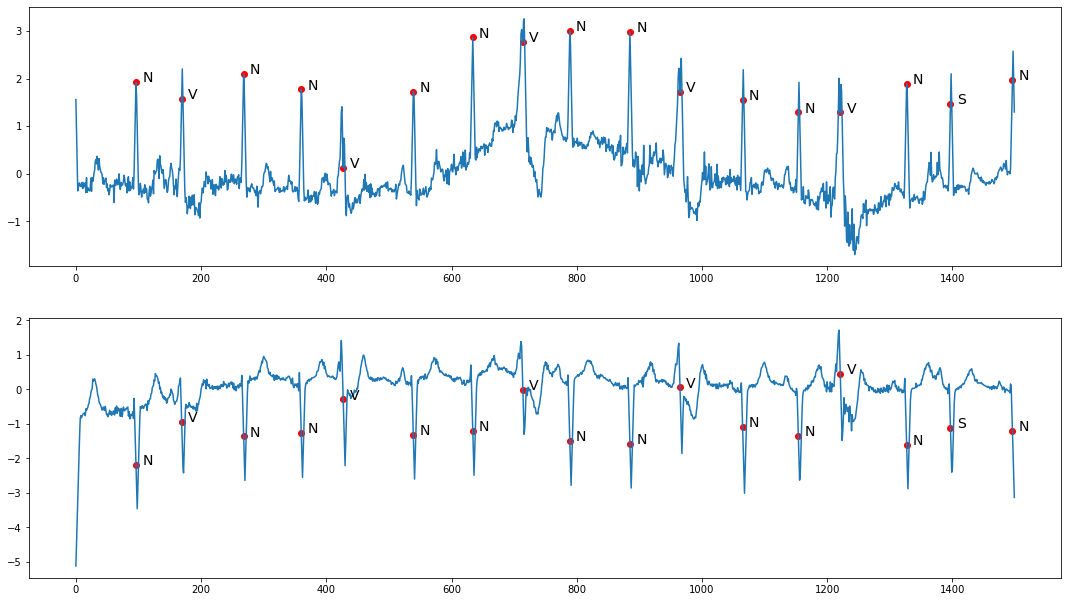

['N', 'N', 'V', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'V']


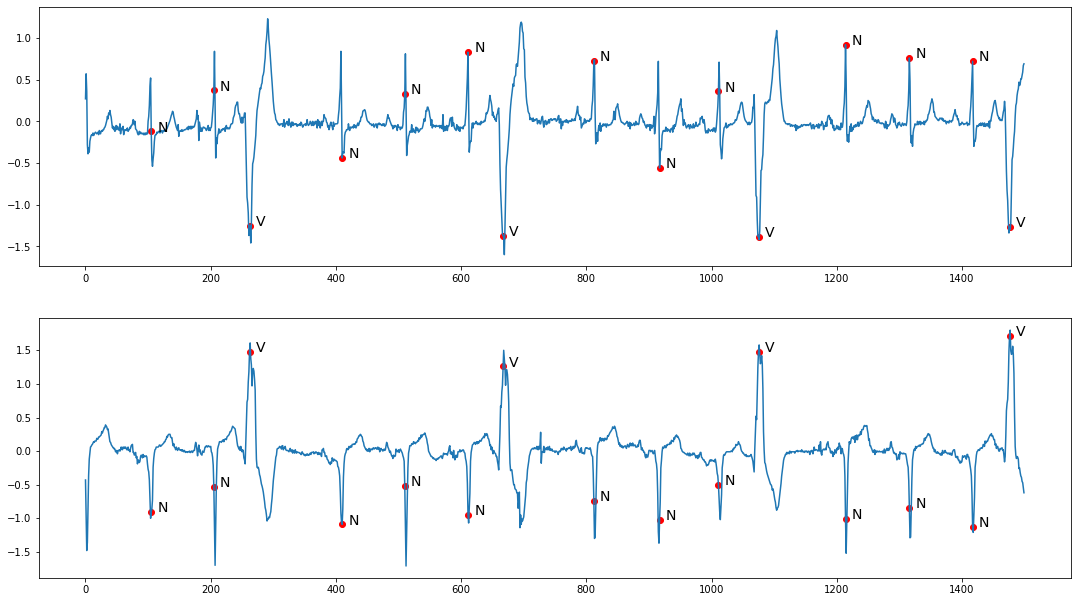

['N', 'N', 'N', 'S', 'N', 'S', 'N', 'N', 'S', 'N', 'N', 'S', 'N', 'V', 'N', 'N', 'N', 'N']


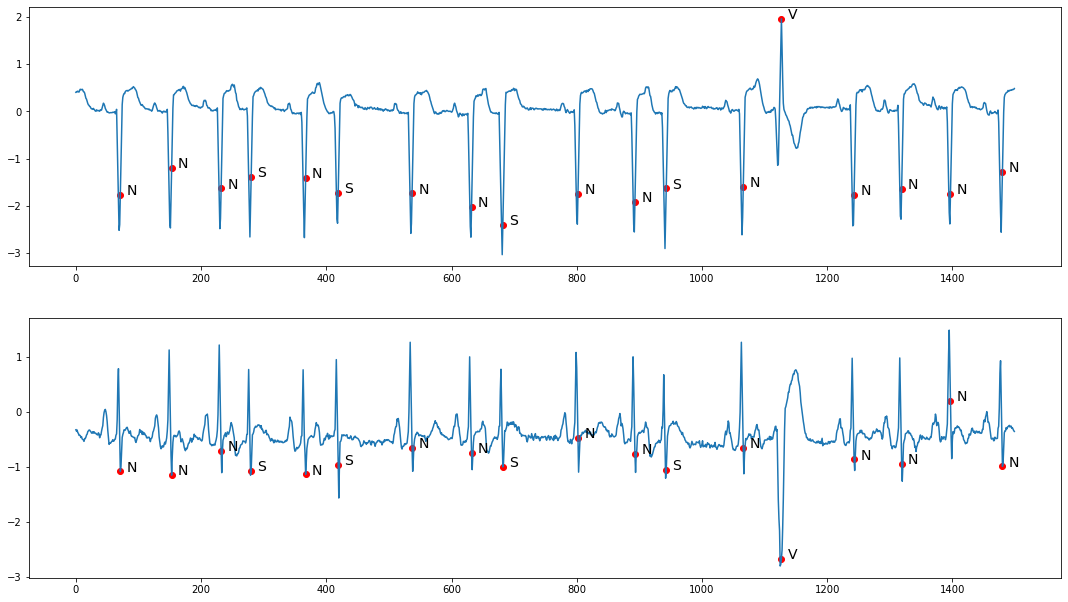

In [7]:
# plot signal 

def plot_signal(df,id,length):
    fig,axs = plt.subplots(2)
    fig.set_size_inches(18.5, 10.5)
    ax1 = axs[0]
    ax2 = axs[1]
    
    signal = df.iloc[id]
    
    first_lead = signal['ecg_lead_1'][:length]
    second_lead = signal['ecg_lead_2'][:length]
    
    peaks_ = signal['peaks']
    labels_ = signal['labels']
    
    x = list(range(length))
    
    ax1.plot(x,first_lead)
    ax2.plot(x,second_lead)
    
    peaks = list()
    p_amplitudes_first = list()
    p_amplitudes_second = list()
    labels = list()
    
    for i,p in enumerate(peaks_):
        if(p <= length):
            peaks.append(p)
            p_amplitudes_first.append(first_lead[p])
            p_amplitudes_second.append(second_lead[p])
            labels.append(labels_[i])
        else:
            break
            
    ax1.scatter(peaks,p_amplitudes_first,color='red')
    ax2.scatter(peaks,p_amplitudes_second,color='red')
    offset = 10
    
    for i, txt in enumerate(labels):
        ax1.annotate(txt, (peaks[i]+offset, p_amplitudes_first[i]),size = 14)
        ax2.annotate(txt, (peaks[i]+offset, p_amplitudes_second[i]),size = 14)
    
    print(labels)
    plt.show()



plot_signal(df,0,1500)
plot_signal(df,1,1500)
plot_signal(df,2,1500)

100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [00:02<00:00, 42.49it/s]


['N', 'V', 'N', 'N', 'V', 'N', 'N', 'V', 'N', 'N', 'V', 'N', 'N', 'V', 'N', 'S', 'N']


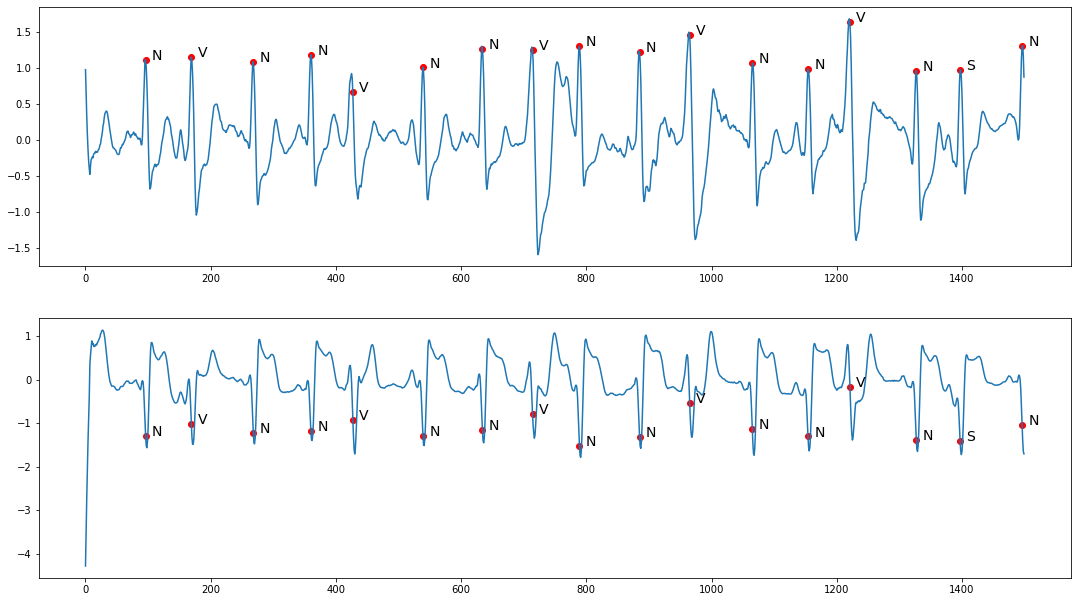

['N', 'N', 'V', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'V']


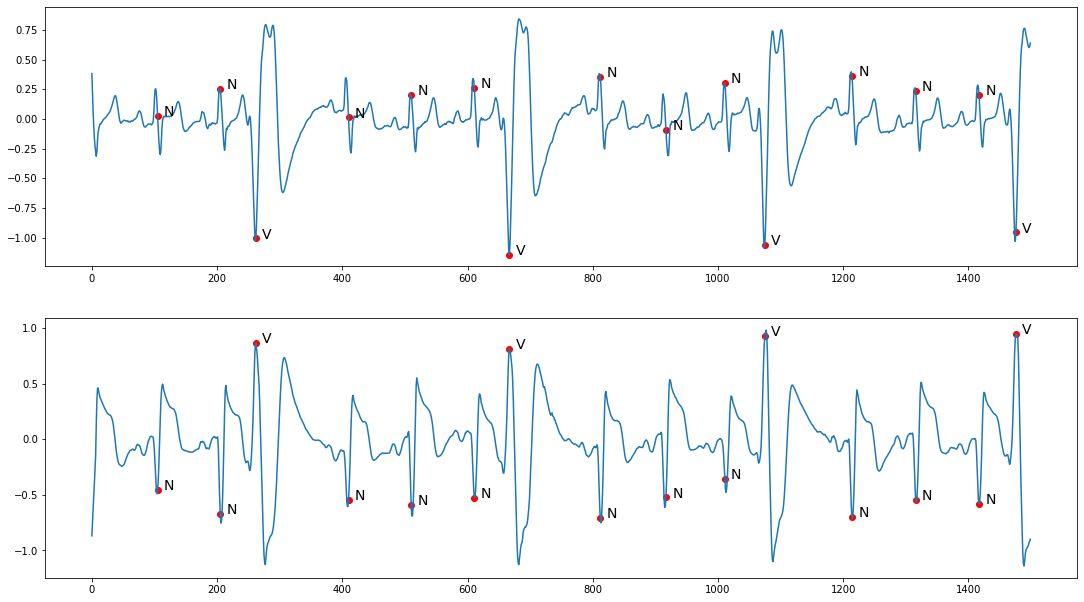

['N', 'N', 'N', 'S', 'N', 'S', 'N', 'N', 'S', 'N', 'N', 'S', 'N', 'V', 'N', 'N', 'N', 'N']


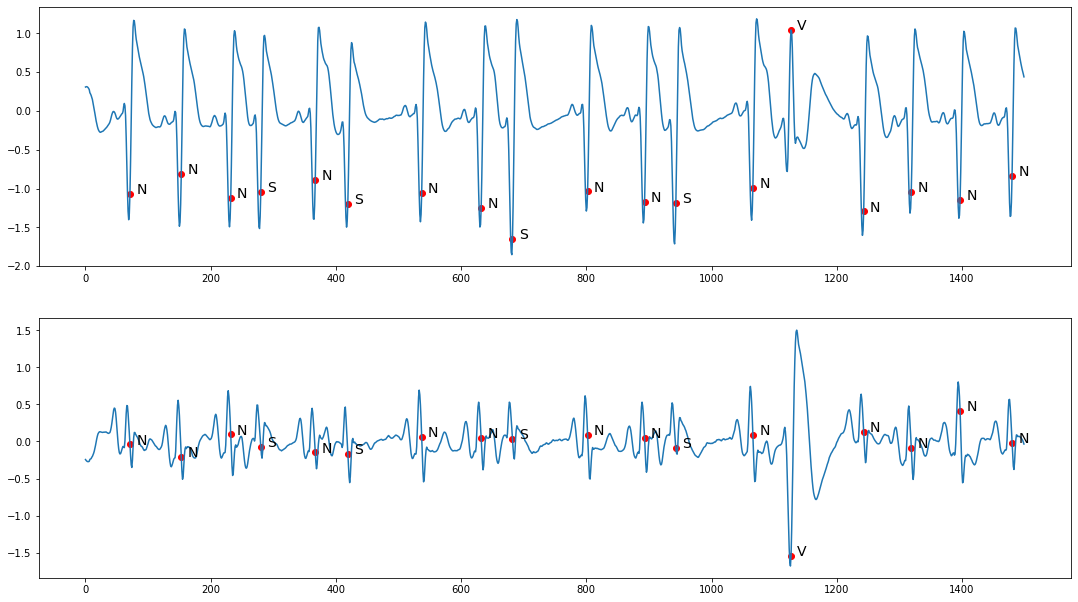

In [8]:
#Preprocessing used in practical lessons



#def bandpass_filter(data, filter_order=5, lowcut = .5, highcut = 55, signal_freq=128):
#def bandpass_filter(data, filter_order=5, lowcut = .5, highcut = 14, signal_freq=128):
def bandpass_filter(data, filter_order=5, lowcut = .5, highcut = 55, signal_freq=128):
        """
        Method responsible for creating and applying Butterworth filter.
        :param deque data: raw data
        :param float lowcut: filter lowcut frequency value
        :param float highcut: filter highcut frequency value
        :param int signal_freq: signal frequency in samples per second (Hz)
        :param int filter_order: filter order
        :return array: filtered data
        """
        nyquist_freq = 0.5 * signal_freq
        low = lowcut / nyquist_freq
        high = highcut / nyquist_freq
        b, a = butter(filter_order, [low, high], btype="band")
        y = lfilter(b, a, data)
        return y

# center signals and remove baseline 
ids = df['sigId'].index
for id in tqdm(ids):
    row = df.iloc[id]
    
    first_sig = np.array(row['ecg_lead_1'])
    second_sig = np.array(row['ecg_lead_2'])
    
    first_sig = bandpass_filter(first_sig)
    second_sig = bandpass_filter(second_sig)

    first_sig = hp.smooth_signal(first_sig, 128, window_length=None, polyorder=2)
    #first_sig = hp.remove_baseline_wander(first_sig, 128,cutoff=0.01)
    second_sig = hp.smooth_signal(second_sig, 128, window_length=None, polyorder=2)
    #second_sig = hp.remove_baseline_wander(second_sig, 128,cutoff=0.01)
    

    # https://swharden.com/blog/2020-09-23-signal-filtering-in-python/
    # create a normalized Hanning window
    #windowSize = 5
    #window = np.hanning(windowSize)
    #window = window / window.sum()
    #first_sig = np.convolve(window, first_sig, mode='same')
    #second_sig = np.convolve(window, second_sig, mode='same')
    #first_sig = ((first_sig - first_sig.min())/(first_sig.max()-first_sig.min())).tolist()
    #second_sig = ((second_sig - second_sig.min())/(second_sig.max()-second_sig.min())).tolist()

    #first_sig = ((first_sig - first_sig.mean())/(first_sig.std()))#.tolist()
    #second_sig = ((second_sig - second_sig.mean())/(second_sig.std()))#.tolist()
    df.iloc[id]['ecg_lead_1'] = first_sig[:]
    df.iloc[id]['ecg_lead_2'] = second_sig[:]

plot_signal(df,0,1500)
plot_signal(df,1,1500)
plot_signal(df,2,1500)


In [ ]:
import gc
del training_patches_df
del training_df
del validation_patches_df
del validation_df
gc.collect()

193

In [ ]:
row = df.loc[48]
len(row['peaks'])

1853

In [9]:
# trying https://arxiv.org/pdf/1805.00794.pdf preprocessing and patch extraction

def convert_to_one_hot(label):
    return np.array(classes == label,dtype=np.float32)

def create_patch_v2(df):
  dataset_dict = {}
  ids = df.index.tolist()
  offset = 0
  for id in tqdm(ids):
      row =  df.loc[id]

      peaks = row['peaks']
      first_sig = row['ecg_lead_1']
      second_sig = row['ecg_lead_2']
      labels = row['labels']  
      #1) Splitting the continuous ECG signal to 10s(1280 samples @128Hz) windows and select a 10s window from an ECG signal.
      for i in range(0, min(len(first_sig), len(second_sig)), 1280):
        first_sig_window = first_sig[i:i+1280]
        second_sig_window = second_sig[i:i+1280]
        #2) Normalizing the amplitude values to the range of between zero and one.
        
        #first_sig_std = (2*((first_sig_window - first_sig_window.min())/(first_sig_window.max()-first_sig_window.min()))-1).tolist()
        #second_sig_std = (2*((second_sig_window - second_sig_window.min())/(second_sig_window.max()-second_sig_window.min()))-1).tolist()
        ###
        #first_sig_std = hp.remove_baseline_wander(first_sig_std, 128,cutoff=0.05)
        #second_sig_std = hp.remove_baseline_wander(second_sig_std, 128,cutoff=0.05)
        ###
        #first_sig[i:i+1280] = first_sig_std
        #second_sig[i:i+1280] = second_sig_std          
        first_sig[i:i+1280] = first_sig_window
        second_sig[i:i+1280] = second_sig_window

      #3) Finding the set of all local maximums based on zerocrossings of the first derivative. NOT NEEDED
      #4) Finding the set of ECG R-peak candidates by applying a threshold of 0.9 on the normalized value of the local maximums. NOT NEEDED
      #5) Finding the median of R-R time intervals as the nominal heartbeat period of that window (T).
      T = 0
      rr_list = list()


      if(len(peaks) != len(labels)):
          print("ERROR")

      for i,peak in enumerate(peaks): #compute each R-R time (in samples)
        if i != len(peaks)-1:
          rr = peaks[i+1]-peaks[i]
          rr_list.append(rr)
          
      
      import statistics

      T = statistics.median(rr_list)
      #6) For each R-peak, selecting a signal part with the length equal to 1.2T.
      #patch_length=2*int(1.5*T)
      #max_len = 500
      
      ###
      patch_length = 500
      max_len = 500
      
      #6B) Setting last peak RR as T
      rr_list.append(T)
      #7) Padding each selected part with zeros to make its length equal to a predefined fixed length.
      for i,peak in enumerate(peaks):
          index = str(id)+'_'+str(i)
          dataset_dict[index] = {}
          first_lead = list()
          second_lead = list()

          #size = list(range(peak-offset,int(max_len+peak)-offset))
          size = list(range(int(peak-max_len/2)+offset,int(peak+max_len/2)+offset))
          if(len(size) != max_len):
              print("error")
          for s in size:
              if(s >= len(first_sig) or s >= (peak + patch_length/2) or s <= (peak -patch_length/2) or s < 0):   # padding with 0
                  first_lead.append(0.) 
                  second_lead.append(0.) 
              else:
                  first_lead.append(first_sig[s])
                  second_lead.append(second_sig[s])
          
          first_lead = np.asarray(first_lead).astype(np.float32)
          second_lead = np.asarray(second_lead).astype(np.float32)
          first_lead = ((first_lead - first_lead.min())/(first_lead.max()-first_lead.min())).tolist()
          second_lead = ((second_lead - second_lead.min())/(second_lead.max()-second_lead.min())).tolist()
          dataset_dict[index]["first_lead"] = first_lead
          dataset_dict[index]["second_lead"] = second_lead
          dataset_dict[index]["RR_d"] = rr_list[i]
          dataset_dict[index]["stringLabel"] = labels[i]
          dataset_dict[index]["label"] = convert_to_one_hot(labels[i])

  dataset_df = pd.DataFrame.from_dict(dataset_dict,orient='index')
  return dataset_df    

classes = np.array(["N","S","V"])
validation_percentage = 0.2
training_df, validation_df = train_test_split(df,test_size = validation_percentage,random_state=SEED)
training_patches_df = create_patch_v2(training_df)
validation_patches_df = create_patch_v2(validation_df)
validation_patches_df



100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [01:36<00:00,  4.60s/it]


,first_lead,second_lead,RR_d,stringLabel,label
65_0,"[0.36430272459983826, 0.36430272459983826, 0.3...","[0.3546924293041229, 0.3546924293041229, 0.354...",87.0,N,"[1.0, 0.0, 0.0]"
65_1,"[0.3716384470462799, 0.3716384470462799, 0.371...","[0.3548683524131775, 0.3548683524131775, 0.354...",86.0,N,"[1.0, 0.0, 0.0]"
65_2,"[0.3644951581954956, 0.2722504734992981, 0.292...","[0.3548683524131775, 0.2449863851070404, 0.243...",88.0,N,"[1.0, 0.0, 0.0]"
65_3,"[0.36166858673095703, 0.1402786374092102, 0.15...","[0.3473258316516876, 0.13588610291481018, 0.14...",89.0,N,"[1.0, 0.0, 0.0]"
65_4,"[0.36166858673095703, 0.19742001593112946, 0.2...","[0.3473258316516876, 0.1597025990486145, 0.173...",90.0,N,"[1.0, 0.0, 0.0]"
...,...,...,...,...,...
48_1848,"[0.4764382243156433, 0.6672113537788391, 0.645...","[0.518233597278595, 0.6835288405418396, 0.6699...",142.0,N,"[1.0, 0.0, 0.0]"
48_1849,"[0.47708284854888916, 0.6182836294174194, 0.59...","[0.5163560509681702, 0.6336145401000977, 0.619...",141.0,N,"[1.0, 0.0, 0.0]"
48_1850,"[0.47860187292099, 0.6160904169082642, 0.59244...","[0.5179102420806885, 0.6324835419654846, 0.618...",143.0,N,"[1.0, 0.0, 0.0]"
48_1851,"[0.48312562704086304, 0.5866912603378296, 0.56...","[0.5179102420806885, 0.6133043766021729, 0.599...",142.0,N,"[1.0, 0.0, 0.0]"


In [ ]:
validation_patches_df[(validation_patches_df['stringLabel']=='S')]

,first_lead,second_lead,RR_d,stringLabel,label
35_7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",105.0,S,"[0.0, 1.0, 0.0]"
35_11,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",104.0,S,"[0.0, 1.0, 0.0]"
35_20,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",105.0,S,"[0.0, 1.0, 0.0]"
35_23,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",104.0,S,"[0.0, 1.0, 0.0]"
35_43,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",104.0,S,"[0.0, 1.0, 0.0]"
...,...,...,...,...,...
48_1229,"[-0.09741499070775281, -0.09758279522787125, -...","[-0.09721634807174412, -0.094487272378742, -0....",164.0,S,"[0.0, 1.0, 0.0]"
48_1231,"[-0.07700789195414906, -0.07566351069996152, -...","[-0.10002096092947413, -0.09961255544668768, -...",160.0,S,"[0.0, 1.0, 0.0]"
48_1233,"[-0.12806136391918074, -0.12862140031245814, -...","[-0.06498537223196829, -0.06732374250132789, -...",164.0,S,"[0.0, 1.0, 0.0]"
48_1239,"[0.0009182009573339187, -0.0003766611462265226...","[-0.05169195809050908, -0.05057568553873129, -...",161.0,S,"[0.0, 1.0, 0.0]"


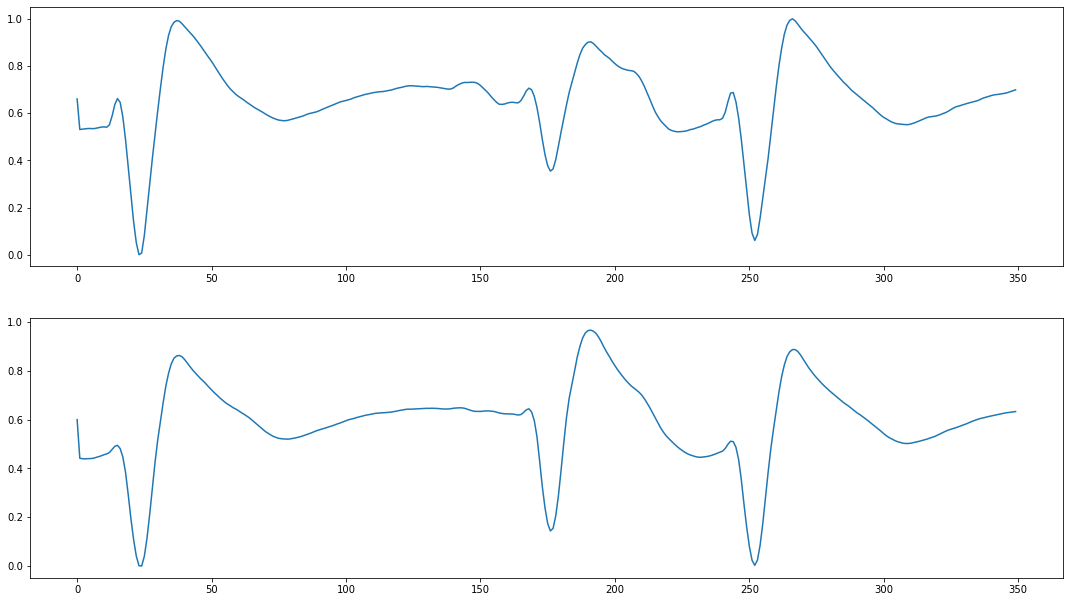

In [10]:
    length = 350
    signal = validation_patches_df.loc["48_1229"]
    fig,axs = plt.subplots(2)
    fig.set_size_inches(18.5, 10.5)
    ax1 = axs[0]
    ax2 = axs[1]
  
    
    first_lead = signal['first_lead'][:length]
    second_lead = signal['second_lead'][:length]
    
    x = list(range(length))
    
    ax1.plot(x,first_lead)
    ax2.plot(x,second_lead)
    
    plt.show()

In [24]:
validation_patches_df[(validation_patches_df['stringLabel']=='V')]

,first_lead,second_lead,RR_d,stringLabel,label
65_58,"[0.48473936319351196, 0.48473936319351196, 0.4...","[0.4765738844871521, 0.4765738844871521, 0.476...",150.0,V,"[0.0, 0.0, 1.0]"
65_75,"[0.4876258373260498, 0.4876258373260498, 0.487...","[0.47953617572784424, 0.47953617572784424, 0.4...",165.0,V,"[0.0, 0.0, 1.0]"
65_154,"[0.4886433780193329, 0.4886433780193329, 0.488...","[0.4828125536441803, 0.4828125536441803, 0.482...",165.0,V,"[0.0, 0.0, 1.0]"
65_156,"[0.46779322624206543, 0.46779322624206543, 0.4...","[0.39948025345802307, 0.39948025345802307, 0.3...",134.0,V,"[0.0, 0.0, 1.0]"
65_158,"[0.4789719879627228, 0.4789719879627228, 0.478...","[0.4806048274040222, 0.4806048274040222, 0.480...",146.0,V,"[0.0, 0.0, 1.0]"
...,...,...,...,...,...
48_1599,"[0.6930779814720154, 0.6930924654006958, 0.693...","[0.6327211260795593, 0.6338476538658142, 0.634...",214.0,V,"[0.0, 0.0, 1.0]"
48_1627,"[0.7929353713989258, 0.7785355448722839, 0.764...","[0.7644162774085999, 0.7485961318016052, 0.733...",173.0,V,"[0.0, 0.0, 1.0]"
48_1684,"[0.7505825757980347, 0.7370216250419617, 0.723...","[0.7118126749992371, 0.6968278288841248, 0.681...",171.0,V,"[0.0, 0.0, 1.0]"
48_1686,"[0.5595133304595947, 0.5654027462005615, 0.571...","[0.5110284090042114, 0.5153935551643372, 0.519...",190.0,V,"[0.0, 0.0, 1.0]"


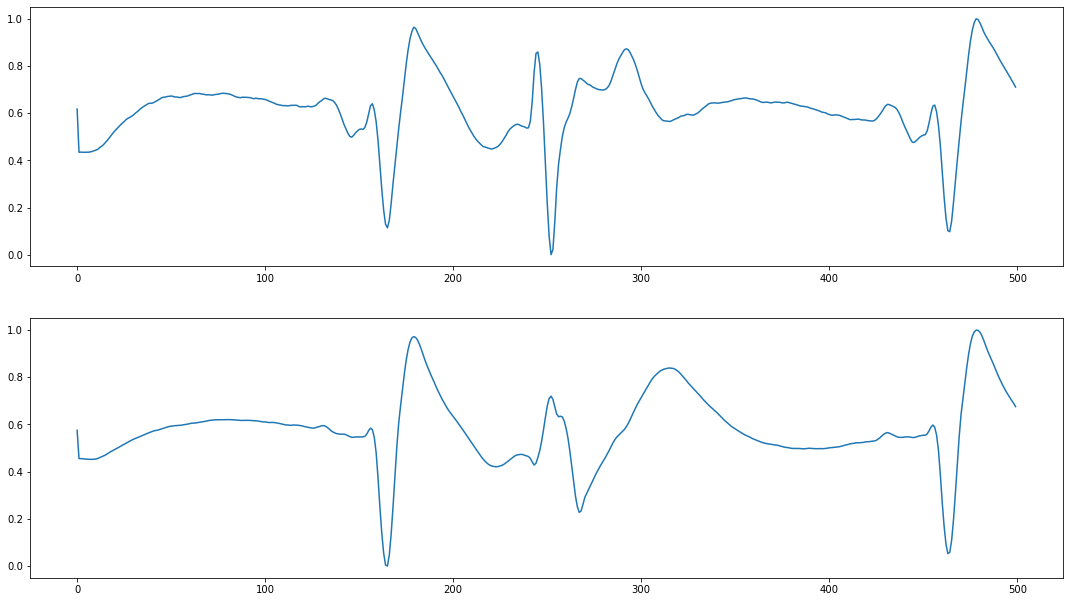

In [11]:
    length = 500
    signal = validation_patches_df.loc["48_1599"]
    fig,axs = plt.subplots(2)
    fig.set_size_inches(18.5, 10.5)
    ax1 = axs[0]
    ax2 = axs[1]
  
    
    first_lead = signal['first_lead'][:length]
    second_lead = signal['second_lead'][:length]
    
    x = list(range(length))
    
    ax1.plot(x,first_lead)
    ax2.plot(x,second_lead)
    
    plt.show()

In [ ]:
num_n_t = len(training_patches_df[(training_patches_df['stringLabel']=='N')])
num_s_t = len(training_patches_df[(training_patches_df['stringLabel']=='S')])
num_v_t = len(training_patches_df[(training_patches_df['stringLabel']=='V')])

num_n_v = len(validation_patches_df[(validation_patches_df['stringLabel']=='N')])
num_s_v = len(validation_patches_df[(validation_patches_df['stringLabel']=='S')])
num_v_v = len(validation_patches_df[(validation_patches_df['stringLabel']=='V')])

print(f'train s%:{num_s_t/(num_s_t+num_v_t+num_n_t)}')
print(f'valid s%:{num_s_v/(num_s_v+num_v_v+num_n_v)}')



train s%:0.038409161093701745
valid s%:0.043200512765730156


In [12]:
# Drop some N samples 
augmenting_coefficient = 2

num_n = len(training_patches_df[(training_patches_df['stringLabel']=='N')])
num_s = len(training_patches_df[(training_patches_df['stringLabel']=='S')])
num_v = len(training_patches_df[(training_patches_df['stringLabel']=='V')])

to_drop =(num_n - (max(num_s,num_v)))*9//10
#to_drop =(num_n - (min(num_s,num_v)))

ids_n = training_patches_df[training_patches_df['stringLabel'] == 'N'].index.tolist()
random.shuffle(ids_n)

ids_to_drop = ids_n[:to_drop]

training_patches_df = training_patches_df.drop(ids_to_drop)

num_n = len(validation_patches_df[(validation_patches_df['stringLabel']=='N')])
num_s = len(validation_patches_df[(validation_patches_df['stringLabel']=='S')])
num_v = len(validation_patches_df[(validation_patches_df['stringLabel']=='V')])

to_drop =(num_n - (max(num_s,num_v)))*9//10
valid_copy = validation_patches_df

ids_n = validation_patches_df[validation_patches_df['stringLabel'] == 'N'].index.tolist()
random.shuffle(ids_n)

ids_to_drop = ids_n[:to_drop]

validation_patches_df = validation_patches_df.drop(ids_to_drop)

Data augmentation

In [ ]:
training_patches_df.head()
ids_ = training_patches_df.index.tolist()
print(type(ids_[0]))
print(ids_[0])

<class 'str'>
83_58


In [ ]:
 
s_to_augment = num_n - to_drop - num_s
v_to_augment = num_n - to_drop - num_v
    
ids_s = training_patches_df[training_patches_df['stringLabel'] == 'S'].index.tolist()
ids_v = training_patches_df[training_patches_df['stringLabel'] == 'V'].index.tolist()
    


In [ ]:
print(v_to_augment)

3223


In [ ]:
print(to_drop)
print(s_to_augment)
print(num_v)

174467
1763
6127


In [ ]:
print(ids_s[0])
print(training_patches_df.loc[ids_s[0]])
print(training_patches_df.loc[(random.choice(ids_v))])

ids_s_to_augment = list()
ids_v_to_augment = list()

for i in range(s_to_augment):
    ids_s_to_augment.append(random.choice(ids_s))

for i in range(v_to_augment):
    ids_v_to_augment.append(random.choice(ids_v))

mean, std_deviation = 0, 0.005
print(type(np.random.normal(mean,std_deviation)))

53_159
first_lead     [0.04951849884557724, 0.06881677732291536, 0.0...
second_lead    [-0.1889408490536182, -0.1871250083090752, -0....
RR_d                                                          93
stringLabel                                                    S
label                                            [0.0, 1.0, 0.0]
Name: 53_159, dtype: object
first_lead     [-0.29097255691282486, -0.3292232511899488, -0...
second_lead    [-0.3110999252688632, -0.3421838858018581, -0....
RR_d                                                          52
stringLabel                                                    V
label                                            [0.0, 0.0, 1.0]
Name: 37_969, dtype: object
<class 'float'>


In [ ]:
i = 0
to_augment = list(ids_s_to_augment+ids_v_to_augment)
for id in tqdm(to_augment):
    
    to_concat = {}
    to_concat[str(i)] = {}    
    to_concat[str(i)]['first_lead'] = list()
    to_concat[str(i)]['second_lead'] = list()
    to_concat[str(i)]['stringLabel'] = training_patches_df.loc[id]['stringLabel']
    to_concat[str(i)]['label'] = training_patches_df.loc[id]['label']

    first_signal = training_patches_df.loc[id]['first_lead']
    second_signal = training_patches_df.loc[id]['second_lead']

    for y in first_signal:
        noise = np.random.normal(mean,std_deviation)
        to_concat[str(i)]['first_lead'].append(y+noise)

    for y in second_signal:
        noise = np.random.normal(mean,std_deviation)
        to_concat[str(i)]['second_lead'].append(y+noise)

    to_concat_df = pd.DataFrame.from_dict(to_concat,orient="index")
    training_patches_df = training_patches_df.append(to_concat_df)
    i += 1



100%|██████████████████████████████████████████████████████████████████████████████| 4986/4986 [01:22<00:00, 60.77it/s]


N: 25210
V: 6127
S: 7587


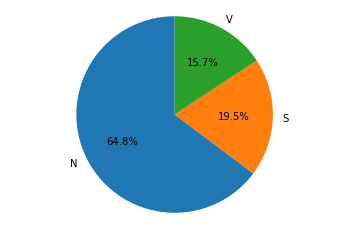

In [16]:
balanced_df = training_patches_df

ids_n = balanced_df.index[balanced_df['stringLabel'] == 'N'].tolist() 
ids_v = balanced_df.index[balanced_df['stringLabel'] == 'V'].tolist() 
ids_s = balanced_df.index[balanced_df['stringLabel'] == 'S'].tolist() 

print(f"N: {len(ids_n)}")
print(f"V: {len(ids_v)}")
print(f"S: {len(ids_s)}")

classes = ["N","S","V"]
counts = [len(ids_n),len(ids_s),len(ids_v)]

fig1, ax1 = plt.subplots()
ax1.pie(counts, explode=None, labels=classes, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.set_facecolor("white")
plt.show()


In [13]:
def create_input(df):
    
    x = list()
    y = list()
    
    for id in tqdm(df.index.tolist()):
        row = df.loc[id]
        x.append(np.transpose(np.asarray([row['first_lead'],row['second_lead']]).astype(np.float32)))
        y.append(row['label'])

    x = np.asarray(x).astype(np.float32)
    y = np.asarray(y).astype(np.float32)
    
    return x,y

In [ ]:
training_patches_df.head()

In [14]:
x_train,y_train = create_input(training_patches_df)
x_valid,y_valid = create_input(validation_patches_df)

100%|████████████████████████████████████████████████████████████████████████████| 9822/9822 [00:01<00:00, 7257.31it/s]


In [15]:
#From lesson 6
def compute_class_freqs(labels):

    N = labels.shape[0]
    
    positive_frequencies = np.sum(labels, axis = 0) / N
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies

def compute_weighted_loss_params(y_train):
    freq_pos, freq_neg = compute_class_freqs(y_train)
    print(f"pos freqs: {freq_pos}")

    print(f"neg freqs: {freq_neg}")

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    plot_occ = pd.DataFrame({"Class": classes, "Label": "Positive", "Value": freq_pos})
    plot_occ = plot_occ.append([{"Class": classes[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
    plt.xticks(rotation=90)
    f = sns.barplot(ax = axes[0], x="Class", y="Value", hue="Label" ,data=plot_occ)
    pos_weights = freq_neg
    neg_weights = freq_pos
    pos_contribution = freq_pos * pos_weights 
    neg_contribution = freq_neg * neg_weights
    plot_occ = pd.DataFrame({"Class": classes, "Label": "Positive", "Value": pos_contribution})
    plot_occ = plot_occ.append([{"Class": classes[l], "Label": "Negative", "Value": v} 
                            for l,v in enumerate(neg_contribution)], ignore_index=True)
    plt.xticks(rotation=90)
    sns.barplot(ax = axes[1], x="Class", y="Value", hue="Label" ,data=plot_occ)
    return pos_weights, neg_weights


def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    def weighted_loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        # initialize loss to zero
        loss = 0.0
        
        for i in range(len(pos_weights)):
            loss += K.mean(-(pos_weights[i] *y_true[:,i] * K.log(y_pred[:,i] + epsilon) 
                             + neg_weights[i]* (1 - y_true[:,i]) * K.log( 1 - y_pred[:,i] + epsilon)))
        return loss    
    return weighted_loss

pos freqs: [0.6476724  0.1949183  0.15740931]
neg freqs: [0.3523276 0.8050817 0.8425907]
Epoch 1/100
608/608 [==============================] - 95s 125ms/step - loss: 0.6061 - precision: 0.8368 - recall: 0.7570 - val_loss: 0.3702 - val_precision: 0.8332 - val_recall: 0.7890
Epoch 2/100
608/608 [==============================] - 73s 121ms/step - loss: 0.2931 - precision: 0.9034 - recall: 0.8848 - val_loss: 0.2843 - val_precision: 0.8986 - val_recall: 0.8790
Epoch 3/100
608/608 [==============================] - 72s 119ms/step - loss: 0.1504 - precision: 0.9444 - recall: 0.9352 - val_loss: 0.7362 - val_precision: 0.7821 - val_recall: 0.7792
Epoch 4/100
608/608 [==============================] - 73s 121ms/step - loss: 0.1247 - precision: 0.9538 - recall: 0.9478 - val_loss: 0.2918 - val_precision: 0.8926 - val_recall: 0.8850
Epoch 5/100
608/608 [==============================] - 73s 120ms/step - loss: 0.1103 - precision: 0.9605 - recall: 0.9555 - val_loss: 0.3514 - val_precision: 0.8831 - 

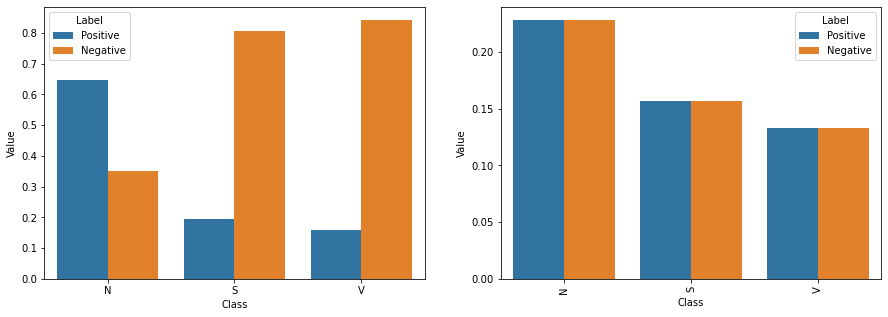

In [16]:
import seaborn as sns
from keras.utils.vis_utils import plot_model
from math import gcd
from sklearn.utils.class_weight import compute_class_weight
import keras.backend as K

batch_size = 64


def ResBs_Conv(block_input, num_filters): 
   
    # 0. Filter Block input and BatchNormalization
    block_input = keras.layers.Conv1D(num_filters, kernel_size=7, strides = 2,  padding = 'same')(block_input) 
    block_input = keras.layers.BatchNormalization()(block_input)

    # 1. First Convolutional Layer
    conv1 = keras.layers.Conv1D(filters=num_filters, kernel_size=7, padding= 'same')(block_input)
    norm1 = keras.layers.BatchNormalization()(conv1)
    relu1 = keras.layers.Activation('relu')(norm1)  
    dropout = keras.layers.Dropout(0.2)(relu1)
    
    # 2. Second Convolutional Layer 
    conv2 = keras.layers.Conv1D(num_filters, kernel_size=7, padding= 'same')(dropout) #per avere concordanza
    norm2 = keras.layers.BatchNormalization()(conv2)

    # 3. Summing Layer (adding a residual connection)
    sum = keras.layers.Add()([block_input, norm2])
    
    # 4. Activation Layer
    relu2 = keras.layers.Activation('relu')(sum)
    
    return relu2 

def ResBs_Identity(block_input, num_filters): 

    # 1. First Convolutional Layer
    conv1 = keras.layers.Conv1D(filters=num_filters, kernel_size=7, padding= 'same')(block_input)
    norm1 = keras.layers.BatchNormalization()(conv1)
    relu1 = keras.layers.Activation('relu')(norm1)    
    dropout = keras.layers.Dropout(0.2)(relu1)
    
    # 2. Second Convolutional Layer 
    conv2 = keras.layers.Conv1D(num_filters, kernel_size=7, padding= 'same')(dropout) #per avere concordanza
    norm2 = keras.layers.BatchNormalization()(conv2)

    # 3. Summing Layer (adding a residual connection)
    sum = keras.layers.Add()([block_input, norm2])
    
    # 4. Activation Layer
    relu2 = keras.layers.Activation('relu')(sum)
    
    return relu2 

#N= number of blocks in resnet, ch = different channels, win_len = common lenght for ecg signals, classes=..
def resnet(input_shape, N=10, custom_loss = None): 
    ecg_input = keras.layers.Input(shape=input_shape, name='ecg_signal') 
    ResNet = keras.layers.Conv1D(filters=64,kernel_size=15, padding = 'same')(ecg_input) 
    ResNet = keras.layers.BatchNormalization()(ResNet)
    ResNet = keras.layers.Activation('relu')(ResNet)
    ResNet = keras.layers.MaxPooling1D(pool_size=2, strides = 2)(ResNet)
    
    # B.5 ResBs (x8) blocks
    # First two ResNet blocks are identity blocks 
    ResNet = ResBs_Identity(ResNet, 64)
    ResNet = ResBs_Identity(ResNet, 64)

    filters = 64
    M= int((N -2 )/2)
    for i in range(M): 
        filters = filters*2
        # define N-th ResBs block
        ResNet = ResBs_Conv(ResNet, filters)
        ResNet = ResBs_Identity(ResNet, filters)
    
    ResNet = keras.layers.GlobalMaxPooling1D(name='gmp_layer')(ResNet)
    #Not necessary?
    #ResNet = Flatten()(ResNet) 

    # Sigmoid activation function on the last layer to retrieve all the combination, instead of softmax
    ResNet = keras.layers.Dense(3, activation='softmax',  name='softmax_classifier')(ResNet)

    # Finally the model is composed by connecting inputs to outputs: 
    model = keras.Model(inputs=[ecg_input],outputs=ResNet)
    return model

nn= resnet(x_train.shape[1:])

callback = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10,
    mode="auto",
    restore_best_weights=True,
)

es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,mode="auto", restore_best_weights=True)
pl=ReduceLROnPlateau(monitor='val_loss',patience=4,factor=0.1,verbose=1,min_lr=1e-11)
callbacks = [es,pl]

pos_weights, neg_weights = compute_weighted_loss_params(y_train)
custom_loss = get_weighted_loss(pos_weights, neg_weights)

learning_rate = 1e-3
nn.compile(
    optimizer = 'adam',
    loss = custom_loss,#'categorical_crossentropy',
    metrics = ['Precision', 'Recall'],
    
)
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(
                                            class_weight = 'balanced', 
                                            classes = np.unique(y_integers), 
                                            y = y_integers 
                                        )
d_class_weights = dict(enumerate(class_weights))

history = nn.fit(
    x = x_train,
    y = y_train, 
    batch_size = batch_size,
    steps_per_epoch=len(x_train)/batch_size,
    validation_data=(x_valid, y_valid),
    epochs = 100,
    shuffle = True,
    callbacks=[callback],
    class_weight = d_class_weights
).history

#validation_data=(X_val_filt, y_val),

  1%|▉                                                                           | 569/46805 [00:00<00:08, 5648.70it/s]

100%|██████████████████████████████████████████████████████████████████████████| 46805/46805 [00:07<00:00, 6150.20it/s]


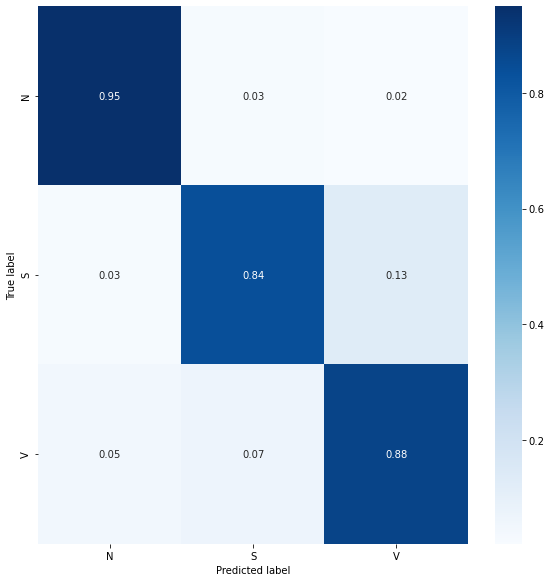

In [17]:

# take also old samples to assess performances 
def plot_confusion_matrix(y_true, y_pred,normalized):
    """
    :param ndarray y_true: contains the ground truth labels in the shape (n_samples,)
    :param ndarray y_pred: contains the predicted labels in the shape (n_samples,)
    """
    con_mat = tf.math.confusion_matrix(labels=y_val_classes, predictions=y_pred).numpy()
    if (normalized):
      con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
      con_mat_df = pd.DataFrame(con_mat_norm,
                      index = classes, 
                      columns = classes)
    else:
        con_mat_df = pd.DataFrame(con_mat,
                      index = classes, 
                      columns = classes)
    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return con_mat


print("Making predictions ...",end="\r")
x_valid_original, y_valid_original = create_input(valid_copy)
y_pred= nn.predict(x_valid_original)

y_pred=np.argmax(y_pred,axis=1)
y_val_classes=np.argmax(y_valid_original, axis=1)

#conf = plot_confusion_matrix(y_val_classes, y_pred,0)
conf = plot_confusion_matrix(y_val_classes, y_pred,1)

In [ ]:
classes = ["N","S","V"]

results = {}

for i,c in enumerate(classes):
    
    results[c] = {}
    
    others = [0,1,2]
    others.remove(i)
    
    results[c]["tp"] = conf[i,i]
    results[c]["fn"] = 0
    results[c]["fp"] = 0
    
    for l in others:
        results[c]["fn"] += conf[i,l]
        results[c]["fp"] += conf[l,i]


sensitivity_n = (results["N"]["tp"])/(results["N"]["tp"]+results["N"]["fn"])
precision_n = (results["N"]["tp"])/(results["N"]["tp"]+results["N"]["fp"])

print(f"sensitivity for N: {sensitivity_n}")
print(f"precision for N: {precision_n}")

sensitivity_s = (results["S"]["tp"])/(results["S"]["tp"]+results["S"]["fn"])
precision_s = (results["S"]["tp"])/(results["S"]["tp"]+results["S"]["fp"])

print(f"sensitivity for S: {sensitivity_s}")
print(f"precision for S: {precision_s}")

sensitivity_v = (results["V"]["tp"])/(results["V"]["tp"]+results["V"]["fn"])
precision_v = (results["V"]["tp"])/(results["V"]["tp"]+results["V"]["fp"])

print(f"sensitivity for V: {sensitivity_v}")
print(f"precision for V: {precision_v}")

sensitivity for N: 0.9402760060303839
precision for N: 0.997784888013783
sensitivity for S: 0.7151335311572701
precision for S: 0.4196169471851422
sensitivity for V: 0.8279376498800959
precision for V: 0.5060461707585197


pos freqs: [0.308805 0.38239  0.308805]
neg freqs: [0.691195 0.61761  0.691195]
Epoch 1/100
155/155 [==============================] - 97s 549ms/step - loss: 10.5943 - precision: 0.3090 - recall: 0.3089 - val_loss: 15.4401 - val_precision: 0.0356 - val_recall: 0.0356
Epoch 2/100
155/155 [==============================] - 84s 542ms/step - loss: 10.6471 - precision: 0.3088 - recall: 0.3088 - val_loss: 15.4401 - val_precision: 0.0356 - val_recall: 0.0356
Epoch 3/100
135/155 [=========================>....] - ETA: 5s - loss: 10.6464 - precision: 0.3089 - recall: 0.3089

KeyboardInterrupt: ignored

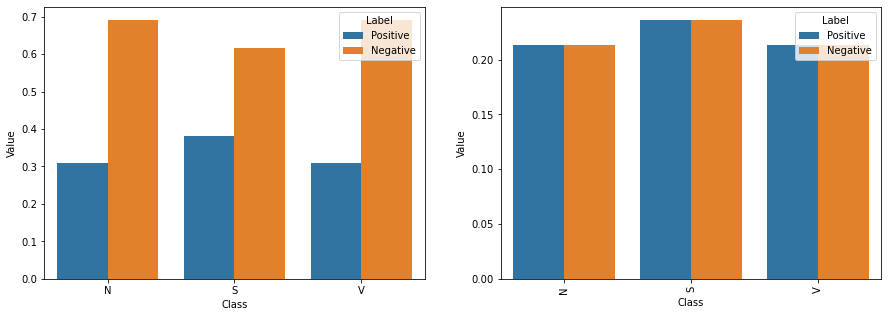

In [ ]:
from keras.initializers import glorot_uniform
import seaborn as sns
from keras.utils.vis_utils import plot_model
from math import gcd
from sklearn.utils.class_weight import compute_class_weight
import keras.backend as K

batch_size = 128

def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = keras.layers.Conv1D(filters=F1, kernel_size=5, strides=s, padding='same', name=conv_name_base + '2a')(X)
    X = keras.layers.BatchNormalization(name=bn_name_base + '2a')(X)
    X = keras.layers.Activation('relu')(X)

    X = keras.layers.Conv1D(filters=F2, kernel_size=5, padding='same', name=conv_name_base + '2b')(X)
    X = keras.layers.BatchNormalization(name=bn_name_base + '2b')(X)
    X = keras.layers.Activation('relu')(X)

    X = keras.layers.Conv1D(filters=F3, kernel_size=5, padding='same', name=conv_name_base + '2c')(X)
    X = keras.layers.BatchNormalization(name=bn_name_base + '2c')(X)

    X_shortcut = keras.layers.Conv1D(filters=F3, kernel_size=5, strides=s, padding='same', name=conv_name_base + '1')(X_shortcut)
    X_shortcut = keras.layers.BatchNormalization(name=bn_name_base + '1')(X_shortcut)

    X = keras.layers.Add()([X, X_shortcut])
    X = keras.layers.Activation('relu')(X)

    return X

def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
        
    X = keras.layers.Conv1D(filters=F1, kernel_size=5, strides=1, padding='same', name=conv_name_base + '2a')(X)
    X = keras.layers.BatchNormalization(name=bn_name_base + '2a')(X)
    X = keras.layers.Activation('relu')(X)

    X = keras.layers.Conv1D(filters=F2, kernel_size=5, strides=1, padding='same', name=conv_name_base + '2b')(X)
    X = keras.layers.BatchNormalization(name=bn_name_base + '2b')(X)
    X = keras.layers.Activation('relu')(X)

    X = keras.layers.Conv1D(filters=F3, kernel_size=5, strides=1, padding='same', name=conv_name_base + '2c')(X)
    X = keras.layers.BatchNormalization(name=bn_name_base + '2c')(X)

    X = keras.layers.Add()([X, X_shortcut])# SKIP Connection
    X = keras.layers.Activation('relu')(X)

    return X

def ResNet50(patch_length=320):

    X_input = keras.layers.Input(shape=(patch_length,2), name='ecg_signal') 


    X = keras.layers.Conv1D(filters=64,kernel_size=7, padding = 'same')(X_input)
    X = keras.layers.BatchNormalization(name='bn_conv1')(X)
    X = keras.layers.Activation('relu')(X)
    X = keras.layers.MaxPooling1D(pool_size=3, strides = 2)(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')


    X = keras.layers.AveragePooling1D(pool_size=2, padding='same')(X)
    
    base_model = tf.keras.Model(inputs=X_input, outputs=X, name='ResNet50')

    headModel = base_model.output
    headModel = keras.layers.Flatten()(headModel)
    headModel= keras.layers.Dense(256, activation='relu', name='fc1')(headModel)
    headModel= keras.layers.Dense(128, activation='relu', name='fc2')(headModel)
    headModel = keras.layers.Dense(3, activation='softmax',  name='softmax_classifier')(headModel)
    model = tf.keras.Model(inputs=base_model.input, outputs=headModel)
    return model

nn= ResNet50()

callback = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10,
    mode="auto",
    restore_best_weights=True,
)

es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,mode="auto", restore_best_weights=True)
pl=ReduceLROnPlateau(monitor='val_loss',patience=4,factor=0.1,verbose=1,min_lr=1e-11)
callbacks = [es,pl]

pos_weights, neg_weights = compute_weighted_loss_params(y_train)
custom_loss = get_weighted_loss(pos_weights, neg_weights)

learning_rate = 1e-3
nn.compile(
    optimizer = 'adam',
    loss = custom_loss,#'categorical_crossentropy',
    metrics = ['Precision', 'Recall'],
    
)
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(
                                            class_weight = 'balanced', 
                                            classes = np.unique(y_integers), 
                                            y = y_integers 
                                        )
d_class_weights = dict(enumerate(class_weights))

history = nn.fit(
    x = x_train,
    y = y_train, 
    batch_size = batch_size,
    steps_per_epoch=len(x_train)/batch_size,
    validation_data=(x_valid, y_valid),
    epochs = 100,
    shuffle = True,
    callbacks=[callback],
    class_weight = d_class_weights
).history